In [1]:
%matplotlib inline

#Source code with the blog post at http://monik.in/a-noobs-guide-to-implementing-rnn-lstm-using-tensorflow/
import numpy as np
import random
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.special as sps
from IPython import display
import time

In [2]:
def load_keystrokes(log_file):
    with open(log_file, 'r') as f:
        data = [[int(i) for i in line.split(',')] for line in f]
    data_count = len(data)
    data = [x for x in data if x[0] > 0]
    clean_data_count = len(data)

    print("Loaded {} events, {} removed".format(clean_data_count, data_count - clean_data_count))
    return data

david_data = load_keystrokes("key_logging/david_keystroke.log")
robert_data = load_keystrokes("key_logging/keystroke.log")

Loaded 104627 events, 120 removed
Loaded 28922 events, 13 removed


In [10]:
# muddle positive time_delta data to generate negative samples
NUM_EXAMPLES = 10000
SEQ_LENGTH = 200

assert all(len(data) >= SEQ_LENGTH for data in [david_data, robert_data]), 'need at least SEQ_LENGTH events'

def random_sub_seq(xs):
    # TODO extend to support variable size sequences
    start = int(np.random.uniform(0, len(xs) - SEQ_LENGTH))
    end = start + SEQ_LENGTH
    return xs[start:end]

train_input = []
train_output = []

for i in range(NUM_EXAMPLES * 10):
    if np.random.rand() < 0.5:
        # positive sample
        train_input.append(random_sub_seq(david_data))
        train_output.append([1, 0])
    else:
        # negative sample
        train_input.append(random_sub_seq(robert_data))
        train_output.append([0, 1])

In [11]:
test_input = train_input[NUM_EXAMPLES:]
test_output = train_output[NUM_EXAMPLES:]
train_input = train_input[:NUM_EXAMPLES]
train_output = train_output[:NUM_EXAMPLES]

print("test and training data loaded")

test and training data loaded


In [5]:
data = tf.placeholder(tf.float32, [None, SEQ_LENGTH,2]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, 2])
num_hidden = 24
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)
weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))
prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
cross_entropy = -tf.reduce_sum(target * tf.log(prediction))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
sess = tf.Session()
saver = tf.train.Saver()

In [12]:
saver.restore(sess, "./model_old.ckpt")
print("Model restored.")

Model restored.


In [8]:
# CAREFUL!!!! only run this cell if you want to clear the model
# if you are restoring from an existing model, don't run this cell

init_op = tf.initialize_all_variables()
sess.run(init_op)
print("inited vars")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
inited vars


In [ ]:
batch_size = 10
no_of_batches = int(len(train_input)) // batch_size
epoch = 10000
print("Batch size: {} || batches: {} || epochs: {}".format(batch_size, no_of_batches, epoch))

error_per_epoch = []

for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    
 
    if i % 1 == 0:
        incorrect = sess.run(error,{data: test_input, target: test_output})
        error_per_epoch.append(incorrect)
        plt.plot(error_per_epoch, color='b')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    # --- comment this out if you don't want to overwrite existing model
    save_path = saver.save(sess, "model.ckpt")

incorrect = sess.run(error,{data: test_input, target: test_output})
print('Epoch {:2d} error {:3.1f}%'.format(i + 1, 100 * incorrect))

Batch size: 10 || batches: 1000 || epochs: 10000


In [14]:
good = [test_input[i] for i in range(len(test_output)) if test_output[i] == [1, 0]]
bad = [test_input[i] for i in range(len(test_output)) if test_output[i] == [0, 1]]

In [15]:
print("true positive: ", sess.run(prediction,{data: good}).mean(axis=0)[0])
print("true negative: ", sess.run(prediction,{data: bad}).mean(axis=0)[1])

true positive:  0.897722
true negative:  0.927723


In [16]:
print(len(good), len(bad))

44969 45031


In [17]:
save_path = saver.save(sess, "model_old.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: model.ckpt


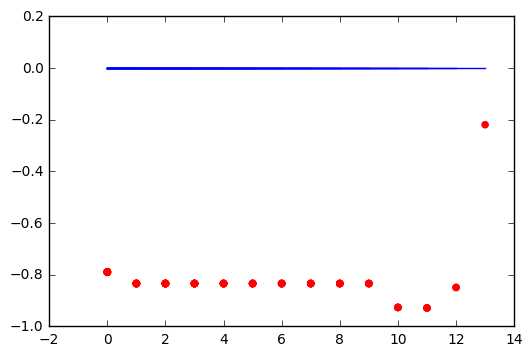

Loaded 29018 events, 13 removed
blah


In [ ]:
# --- classify the latest keystrokes ----
history = []
while 1:
    current_keystrokes = load_keystrokes('./key_logging/keystroke.log')[-SEQ_LENGTH:]

    inp, out = [current_keystrokes], [[1,0]]
    result = sess.run(prediction,{data: inp}).mean(axis=0)
    print('blah')
    history.append((result[0] - 0.5) * 2)
    plt.scatter(range(len(history)), history, color=['g' if h > 0 else 'r' for h in history])
    plt.plot([0] * len(history), color='b')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1)

# --- can retrain model with this data --- 
#sess.run(minimize,{data: inp, target: out})
#print(sess.run(prediction,{data: [current_keystrokes]}).mean(axis=0))

In [ ]:
# don't run this before you save the model if you want to save the model
sess.close()